# Image Data Augmentation

Haohang Li  
2021/10/18

### Dependencies

In [1]:
! pip install torchinfo
! pip install gdown  # download large file from Google Drive

In [2]:
import os
import shutil
import glob
import random
import concurrent
import zipfile
import torch
import PIL
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from IPython.display import Image
from torchinfo import summary

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

### Download data & unzip:

In [4]:
! gdown https://drive.google.com/uc?id=1ItGv65UmiQKnett7vxY1qNPTXRg4hSfW

Downloading...
From: https://drive.google.com/uc?id=1ItGv65UmiQKnett7vxY1qNPTXRg4hSfW
To: /content/dog_cat.zip
100% 570M/570M [00:06<00:00, 86.3MB/s]


In [5]:
with zipfile.ZipFile('/content/dog_cat.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

### Re-organize data & generate small sample:

Dir structure:

In [6]:
# cwd
cwd = os.getcwd()
print(cwd)
# dirs
dog_cat_dir = os.path.join(cwd, 'dog_cat')
if not os.path.exists(dog_cat_dir):
    os.mkdir(dog_cat_dir)

cat_dir = os.path.join(dog_cat_dir, 'cat')
if not os.path.exists(cat_dir):
    os.mkdir(cat_dir)
    
dog_dir = os.path.join(dog_cat_dir, 'dog')
if not os.path.exists(dog_dir):
    os.mkdir(dog_dir)

# sample random 1000 pics for cats & dogs
cat_pics = np.random.choice(glob.glob(os.path.join(cwd, 'train', 'cat.*.jpg')), size=1000, replace=False)
dog_pics = np.random.choice(glob.glob(os.path.join(cwd, 'train', 'dog.*.jpg')), size=1000, replace=False)

# move to dir
def move_to_folder(scr_file, des_folder):
    des_name = os.path.basename(scr_file)
    shutil.copyfile(scr_file, os.path.join(des_folder, des_name))
# cats
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, cat_dir) for file_name in cat_pics]
# dogs
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as pool:
    [pool.submit(move_to_folder, file_name, dog_dir) for file_name in dog_pics]

/content


In [7]:
print(os.listdir(cat_dir)[:10])
print(os.listdir(dog_dir)[:10])

['cat.11494.jpg', 'cat.2688.jpg', 'cat.2876.jpg', 'cat.1365.jpg', 'cat.2244.jpg', 'cat.11672.jpg', 'cat.10269.jpg', 'cat.2443.jpg', 'cat.8453.jpg', 'cat.8763.jpg']
['dog.12272.jpg', 'dog.11851.jpg', 'dog.10009.jpg', 'dog.5278.jpg', 'dog.12273.jpg', 'dog.12318.jpg', 'dog.8033.jpg', 'dog.6208.jpg', 'dog.11353.jpg', 'dog.3919.jpg']


### Show a cat and dog example

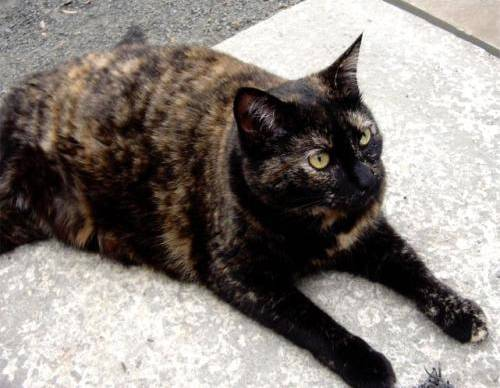

In [8]:
Image(os.path.join(cat_dir, os.listdir(cat_dir)[0]))

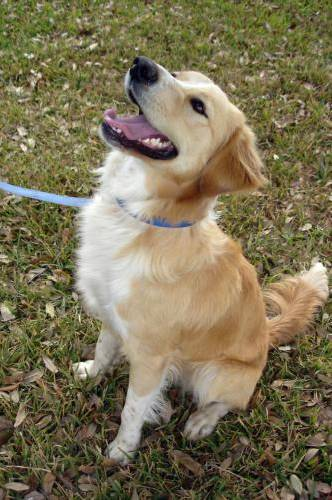

In [9]:
Image(os.path.join(dog_dir, os.listdir(dog_dir)[0]))

## Define Model

In [10]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        # Conv net
        self.convnet = nn.Sequential(
            # input(3, 150, 150)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # (32, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (32, 74, 74)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # (64, 72, 72)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (64, 36, 36)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),  # (128, 34, 34)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 17, 17)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),  # (128, 15, 15)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (128, 7, 7)
            nn.Flatten() # 6272 = 128 * 7 * 7
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )
    
    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)

        return x

In [11]:
sample_model = CNN_Classifier()
summary(sample_model, (10, 3, 150, 150))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
CNN_Classifier                           --                        --
├─Sequential: 1-1                        [10, 6272]                --
│    └─Conv2d: 2-1                       [10, 32, 148, 148]        896
│    └─ReLU: 2-2                         [10, 32, 148, 148]        --
│    └─MaxPool2d: 2-3                    [10, 32, 74, 74]          --
│    └─Conv2d: 2-4                       [10, 64, 72, 72]          18,496
│    └─ReLU: 2-5                         [10, 64, 72, 72]          --
│    └─MaxPool2d: 2-6                    [10, 64, 36, 36]          --
│    └─Conv2d: 2-7                       [10, 128, 34, 34]         73,856
│    └─ReLU: 2-8                         [10, 128, 34, 34]         --
│    └─MaxPool2d: 2-9                    [10, 128, 17, 17]         --
│    └─Conv2d: 2-10                      [10, 128, 15, 15]         147,584
│    └─ReLU: 2-11                        [10, 128, 15, 15]         --
│

## Dataset

### Self-defined Dataset:

In [12]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index] # mini batch
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

In [13]:
images_list = glob.glob(os.path.join(dog_cat_dir, '*', '*.jpg'))
# label: 0 for cat, 1 for dog
def extract_class(img_path):
    base_path = os.path.basename(img_path)
    return base_path.split('.')[0]

labels = [0 if extract_class(cur_path) == 'cat' else 1 for cur_path in images_list]

In [14]:
resize_transforms = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor()])

In [15]:
dog_cat_dataset = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=resize_transforms)

In [16]:
dog_cat_dataset[0]

(tensor([[[0.4000, 0.5176, 0.6235,  ..., 0.3059, 0.3608, 0.3647],
          [0.4157, 0.4510, 0.4588,  ..., 0.3608, 0.3725, 0.3569],
          [0.3686, 0.3765, 0.4196,  ..., 0.4039, 0.3608, 0.3451],
          ...,
          [0.4549, 0.3373, 0.2784,  ..., 0.5255, 0.4745, 0.3569],
          [0.4431, 0.3529, 0.3176,  ..., 0.2039, 0.2706, 0.2157],
          [0.3804, 0.2824, 0.3294,  ..., 0.2314, 0.3020, 0.3137]],
 
         [[0.3961, 0.5020, 0.6118,  ..., 0.3255, 0.3804, 0.3804],
          [0.4471, 0.4745, 0.4745,  ..., 0.3843, 0.4118, 0.4118],
          [0.4275, 0.4314, 0.4667,  ..., 0.4235, 0.3961, 0.4039],
          ...,
          [0.3882, 0.2824, 0.2353,  ..., 0.4118, 0.3569, 0.2431],
          [0.3686, 0.2863, 0.2706,  ..., 0.1059, 0.1608, 0.1098],
          [0.3294, 0.2157, 0.2471,  ..., 0.1843, 0.2000, 0.1725]],
 
         [[0.2588, 0.4157, 0.5216,  ..., 0.0863, 0.1373, 0.1529],
          [0.2549, 0.3176, 0.3294,  ..., 0.1529, 0.1608, 0.1529],
          [0.1882, 0.1961, 0.2510,  ...,

### ImageFolder:

In [17]:
from torchvision.datasets import ImageFolder
dog_cat_dataset_folder = ImageFolder(dog_cat_dir, transform=transforms.ToTensor())

In [18]:
dog_cat_dataset_folder[0]

(tensor([[[0.9255, 0.9255, 0.9294,  ..., 0.8353, 0.8314, 0.8314],
          [0.9255, 0.9294, 0.9294,  ..., 0.8275, 0.8235, 0.8235],
          [0.9255, 0.9294, 0.9333,  ..., 0.8431, 0.8392, 0.8392],
          ...,
          [0.7843, 0.8118, 0.8549,  ..., 0.9059, 0.9059, 0.9137],
          [0.7922, 0.8078, 0.8353,  ..., 0.9294, 0.9255, 0.9294],
          [0.8275, 0.8235, 0.8353,  ..., 0.9216, 0.9255, 0.9216]],
 
         [[0.5882, 0.5882, 0.5922,  ..., 0.6706, 0.6745, 0.6745],
          [0.5882, 0.5922, 0.5922,  ..., 0.6627, 0.6667, 0.6667],
          [0.5882, 0.5922, 0.5961,  ..., 0.6784, 0.6824, 0.6824],
          ...,
          [0.3686, 0.3843, 0.3961,  ..., 0.5569, 0.5569, 0.5647],
          [0.3647, 0.3686, 0.3725,  ..., 0.5725, 0.5765, 0.5804],
          [0.3961, 0.3765, 0.3725,  ..., 0.5647, 0.5686, 0.5765]],
 
         [[0.5843, 0.5843, 0.5882,  ..., 0.7176, 0.7176, 0.7176],
          [0.5843, 0.5882, 0.5882,  ..., 0.7098, 0.7098, 0.7098],
          [0.5843, 0.5882, 0.5922,  ...,

### Split Dataset

In [19]:
split_size = (np.array([0.6, 0.2, 0.2]) * len(dog_cat_dataset)).round().astype(np.int)
train_data, valid_data, test_data = random_split(dog_cat_dataset, split_size)

## Train Function

In [20]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0001, epochs=30, batch_size=256):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}
    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)  # (num_batch)
            cur_train_loss = criterion(outputs, y)
            pred = torch.sigmoid(outputs)
            pred = torch.round(pred)
            cur_train_acc = (pred == y).sum().item() / batch_size
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).sum().item() / batch_size 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f} train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
    
    return history

## Train Model

In [21]:
cnn_model = CNN_Classifier()

In [22]:
history = train_model(cnn_model, train_data, valid_data, device, batch_size=32, epochs=30, lr=0.0001)

Training Start
Epoch:1 / 30, train loss:0.6945 train_acc:0.5074, valid loss:0.6838 valid acc:0.5938
Epoch:2 / 30, train loss:0.6857 train_acc:0.5535, valid loss:0.6678 valid acc:0.5938
Epoch:3 / 30, train loss:0.6711 train_acc:0.5806, valid loss:0.6537 valid acc:0.6298
Epoch:4 / 30, train loss:0.6632 train_acc:0.5806, valid loss:0.6443 valid acc:0.6178
Epoch:5 / 30, train loss:0.6560 train_acc:0.6028, valid loss:0.6564 valid acc:0.6058
Epoch:6 / 30, train loss:0.6463 train_acc:0.6258, valid loss:0.6310 valid acc:0.6394
Epoch:7 / 30, train loss:0.6372 train_acc:0.6184, valid loss:0.7488 valid acc:0.5120
Epoch:8 / 30, train loss:0.6289 train_acc:0.6340, valid loss:0.6132 valid acc:0.6659
Epoch:9 / 30, train loss:0.6153 train_acc:0.6513, valid loss:0.6214 valid acc:0.6202
Epoch:10 / 30, train loss:0.5980 train_acc:0.6637, valid loss:0.6124 valid acc:0.6731
Epoch:11 / 30, train loss:0.5914 train_acc:0.6801, valid loss:0.6352 valid acc:0.6178
Epoch:12 / 30, train loss:0.5753 train_acc:0.688

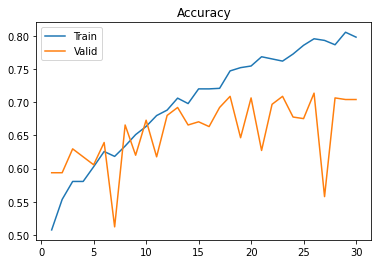

In [23]:
plt.plot(range(1, 31), history['train_acc'], label='Train')
plt.plot(range(1, 31), history['test_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

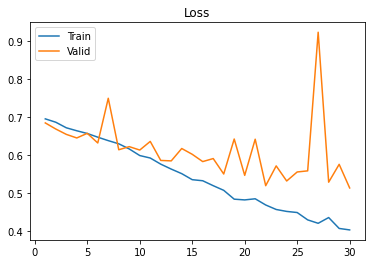

In [24]:
plt.plot(range(1, 31), history['train_loss'], label='Train')
plt.plot(range(1, 31), history['test_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

## Image Data Augmentation

The image transformations are implemented in [torchvision](https://pytorch.org/vision/stable/index.html). Some useful data augmentations:

*   [torchvision.transforms.ColorJitter](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter): Randomly change the brightness, contrast, saturation and hue of an image.
*   [torchvision.transforms.RandomHorizontalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomHorizontalFlip) & [torchvision.transforms.RandomVerticalFlip](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomVerticalFlip): Horizontally or vertically flip the given image randomly with a given probability.
*   [torchvision.transforms.RandomGrayscale(p=0.1)](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomGrayscale): Randomly convert image to grayscale with a a probability.
*   [RandomRotation](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation): Randomly rotate images within certain degrees.






For the full list of availabe tranformations, please see [this](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation). The illustrations of transformations are available [here](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py).

### Image Transformation Example

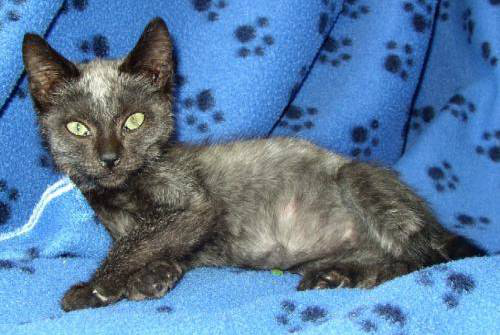

In [25]:
# get a sample image
sample_img_path = os.path.join(cat_dir, os.listdir(cat_dir)[4])
sample_img = PIL.Image.open(sample_img_path)
display(sample_img)

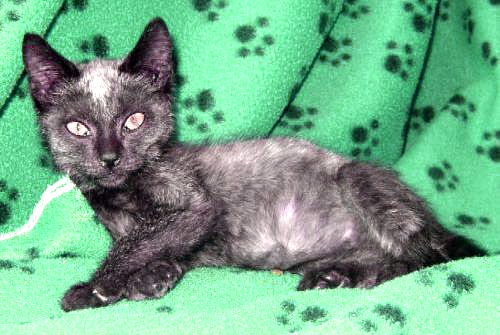

In [26]:
# apply random color jitter
transformed_img = transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(sample_img)
display(transformed_img)

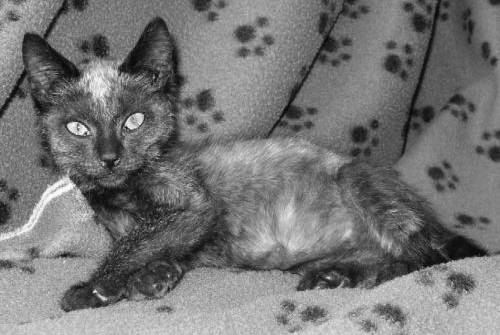

In [27]:
transformed_img = transforms.RandomGrayscale(p=1.0)(sample_img)
display(transformed_img)

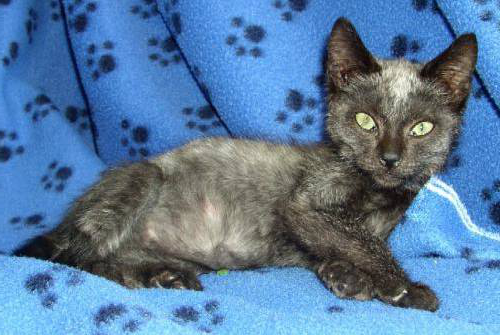

In [28]:
transformed_img = transforms.RandomHorizontalFlip(p=1.0)(sample_img)
display(transformed_img)

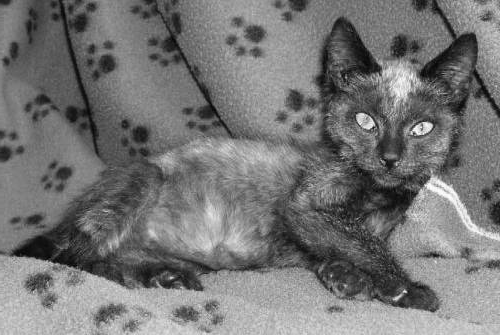

In [29]:
# Chain the transformations to a pipeline
transform_pipeline = transforms.Compose(
    [transforms.RandomGrayscale(p=1.0), 
     transforms.RandomHorizontalFlip(p=1.0)])

transformed_img = transform_pipeline(sample_img)
display(transformed_img)

### Apply Transfoamation on Dataset

In [30]:
class ImgDataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        if img_transforms is None:
            self.transforms = transforms.ToTensor()
        else:
            self.transforms = img_transforms
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path)
        cur_img = self.transforms(cur_img)

        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

Build a transformation pipeline:

In [31]:
transformations = transforms.Compose([transforms.Resize((150, 150)),  # resize to input shape of our CNN
                                      transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                                      transforms.RandomRotation(40),
                                      transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()  # convert PIL to Tensor
                                      ])

New dataset with transformation pipline:

In [32]:
dog_cat_dataset_transformed = ImgDataset(img_path=images_list, img_labels=labels, img_transforms=transformations)

split_size = (np.array([0.6, 0.2, 0.2]) * len(dog_cat_dataset_transformed)).round().astype(np.int)
train_data, valid_data, test_data = random_split(dog_cat_dataset_transformed, split_size)

### Re-Train CNN Model:

In [33]:
cnn_model = CNN_Classifier()

In [34]:
history = train_model(cnn_model, train_data, valid_data, device, batch_size=32, epochs=150, lr=0.0001)

Training Start
Epoch:1 / 150, train loss:0.6972 train_acc:0.5214, valid loss:0.6876 valid acc:0.5433
Epoch:2 / 150, train loss:0.6860 train_acc:0.5559, valid loss:0.6814 valid acc:0.5625
Epoch:3 / 150, train loss:0.6813 train_acc:0.5658, valid loss:0.6756 valid acc:0.5649
Epoch:4 / 150, train loss:0.6781 train_acc:0.5551, valid loss:0.6879 valid acc:0.5312
Epoch:5 / 150, train loss:0.6777 train_acc:0.5658, valid loss:0.6781 valid acc:0.5096
Epoch:6 / 150, train loss:0.6748 train_acc:0.5674, valid loss:0.6672 valid acc:0.5938
Epoch:7 / 150, train loss:0.6661 train_acc:0.5880, valid loss:0.6892 valid acc:0.5168
Epoch:8 / 150, train loss:0.6690 train_acc:0.6086, valid loss:0.6688 valid acc:0.5721
Epoch:9 / 150, train loss:0.6636 train_acc:0.5954, valid loss:0.6842 valid acc:0.5337
Epoch:10 / 150, train loss:0.6534 train_acc:0.6069, valid loss:0.7007 valid acc:0.5120
Epoch:11 / 150, train loss:0.6492 train_acc:0.6160, valid loss:0.6824 valid acc:0.5529
Epoch:12 / 150, train loss:0.6477 tra

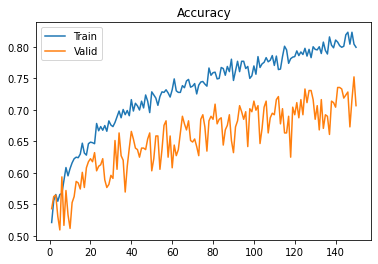

In [35]:
plt.plot(range(1, 151), history['train_acc'], label='Train')
plt.plot(range(1, 151), history['test_acc'], label='Valid')
plt.title('Accuracy')
plt.legend()
plt.show()

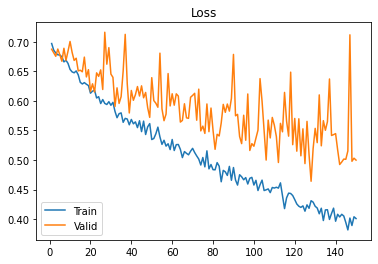

In [36]:
plt.plot(range(1, 151), history['train_loss'], label='Train')
plt.plot(range(1, 151), history['test_loss'], label='Valid')
plt.title('Loss')
plt.legend()
plt.show()

In [37]:
# image net  -> paper, help in picking optimum augmentation